In [ ]:
import numpy as np

# Code is made with the help of OpenAI's ChatGPT:
# https://chatgpt.com/g/g-p-6810f3bf9bf0819194c8005b53869516-option-pricing/c/681ad563-c208-800b-ba3e-0dabde2454c1

In [48]:
# Exponential Ornstein-Uhlenbeck process

class XOU:

    def __init__(self, kappa, alpha, sigma, S0, r):

        self.kappa = kappa
        self.alpha = alpha
        self.sigma = sigma
        self.S0 = S0
        self.r = r

In [49]:
hw6dynamics=XOU(kappa = 0.472, alpha = 4.4, sigma = 0.368, S0 = 106.9, r = 0.05)

In [50]:
class CallOnForwardPrice:

    def __init__(self, K1, T1, T2):

        self.K1 = K1
        self.T1 = T1
        self.T2 = T2


In [51]:
hw6contract=CallOnForwardPrice(K1 = 103.2, T1 = 0.5, T2 = 0.75)

In [ ]:
class MCengine:

    def __init__(self, N, M, epsilon, seed):

        self.N = N   # Number of timesteps on each path
        self.M = M   # Number of paths
        self.epsilon = epsilon  # For the dC/dS calculation
        self.rng = np.random.default_rng(seed=seed) # Seeding the random number generator with a specified number helps make the calculations reproducible

    def price_call_XOU(self, contract, dynamics):

        # You complete the coding of this function
        # self.rng.normal() generates pseudo-random normals
        
        dt = contract.T1 / self.N
        M = self.M
        eps = self.epsilon 
        
        kappa = dynamics.kappa
        alpha = dynamics.alpha
        sigma = dynamics.sigma
        sigma_squared = sigma ** 2
        r = dynamics.r
        T1 = contract.T1
        T2 = contract.T2
        K = contract.K1
        
        # Compute initial values
        X0 = np.log(dynamics.S0)
        X0_eps = np.log(dynamics.S0 + eps)
        
        # Simulate X_t path to T1
        # Generate M simulations, each simulation starting with the initial value X0
        X = np.full(M, X0) 
        X_eps = np.full(M, X0_eps) 

        
        for _ in range(self.N):
            
            # These are the shocks, random Brownian motion
            dWt = self.rng.normal(loc = 0.0, scale = np.sqrt(dt), size=M)
            
            # Equation for dXt (given)
            dXt = kappa * (alpha - X) * dt + sigma * dWt
            dXt_eps = kappa * (alpha - X_eps) * dt + sigma * dWt

            # Euler Method for simulated path (L5.14)
            # These are the simulated trajectories of the log-spot price
            X += dXt
            X_eps += dXt_eps

        # Compute S_T1 from X_T1
        # The value of the asset at the option's expiry
        S_T1 = np.exp(X)
        S_T1_eps = np.exp(X_eps)
        
        # Compute the Forward Price F_T1 for T2 delivery
        # Use the equation for F_t given
        decay = np.exp(-kappa * (T2 - T1))
        var_term = (sigma_squared / (4 * kappa)) * (1 - np.exp(-2 * kappa * (T2 - T1)) )
        
        exponent_part = decay * np.log(S_T1) + (1 - decay) * alpha + var_term
        exponent_part_eps = decay * np.log(S_T1_eps) + (1 - decay) * alpha + var_term
        
        # Price of the forward contract for delivery at T2, viewed from time T1
        F_T1 = np.exp(exponent_part)
        F_T1_eps = np.exp(exponent_part_eps)

        # Discounted Payoff (Y) based on L5.3 
        discount_factor = np.exp(-r * T1) 
        payoff = discount_factor * np.maximum(F_T1 - K, 0)
        payoff_eps = discount_factor * np.maximum(F_T1_eps - K, 0)

        # Compute Monte Carlo Estimate for the Call Price (L5.3), which is the average of Y
        call_price = np.mean(payoff)
        
        # Standard Error of the MC Estimate (L5.4)
        # Var(Cm) = sigma_squared / M
        # Std(Cm) = sigma / np.sqrt(M)
        standard_error = np.std(payoff, ddof=1) / np.sqrt(M)
        
        # Delta estimate via finite difference (eps = 0.01 for finite difference)
        call_delta = (np.mean(payoff_eps) - np.mean(payoff)) / eps

        return(call_price, standard_error, call_delta, F_T1)
    
    # For 1.e)
    def forward_sensitivity(self, contract, dynamics):
        "Computes df0/ds analytically"
        kappa = dynamics.kappa
        alpha = dynamics.alpha
        sigma = dynamics.sigma
        sigma_squared = sigma ** 2
        r = dynamics.r
        T2 = contract.T2
        K = contract.K1      
        S0 = dynamics.S0  
        
        decay = np.exp(-kappa * T2)
        decay_squared = np.exp(-2 * kappa * T2)
        discount_factor = np.exp(-r * T2) 
        
        var_term = (sigma_squared / (4 * kappa)) * (1 - decay_squared)
        exp_part = (1 - decay) * alpha +  var_term

        forward_sens = discount_factor * (1 - decay * (S0 ** (decay-1)) * np.exp(exp_part))
        
        return forward_sens



# Problem 1. c) and d)

In [53]:
num_simulations = 100_000
hw6MC = MCengine(N=100, M=num_simulations, epsilon=0.01, seed=0) # Change M if necessary
(call_price, standard_error, call_delta, F_T1) = hw6MC.price_call_XOU(hw6contract,hw6dynamics)
print(call_price, standard_error, call_delta)

print(f"Call Price: {call_price:.4f}")
print(f"Standard Error: {standard_error:.4f}, which is less than 0.05 using {num_simulations:,} simulations")
print(f"Call Delta: {call_delta:.4f}")

7.741671334651302 0.04200158522525294 0.34111144701913787
Call Price: 7.7417
Standard Error: 0.0420, which is less than 0.05 using 100,000 simulations
Call Delta: 0.3411


# Problem 1.e) and f)

Hedge Ratio = How many forward contracts to hold per one unit of call option exposure

In [54]:
# Use the function above
df0_dS = hw6MC.forward_sensitivity(hw6contract,hw6dynamics)

# Hedge Ratio = ( dC/dS) / (df_0/dS)
hedge_ratio = call_delta / df0_dS

print(f"Call Delta: {call_delta:.4f}")
print(f"df0/dS (Forward Sensitivity): {df0_dS:.4f}")
print(f"Hedge Ratio (contracts per call): {hedge_ratio:.4f}")

Call Delta: 0.3411
df0/dS (Forward Sensitivity): 0.3167
Hedge Ratio (contracts per call): 1.0771


# Problem 1.g)

In [ ]:
def purchase_agreement_value(F_T1_array, K, r, T1):
    "Compute time-0 value of the purchase contract using stored F_T1 from part C"
    theta = np.where(F_T1_array > K, 5_000, 4_000)
    payoff = theta * (F_T1_array - K)
    discounted_payoff = np.exp(-r * T1) * payoff
    
    time0_value = np.mean(discounted_payoff)
    
    return time0_value

# Input
F_T1_array = F_T1 # From earlier
r = 0.05
K = 103.2
T1 = 0.5

time0_value = purchase_agreement_value(F_T1_array, K, r, T1)

print(f"Time-0 Value of the 'Purchase Agreement' Contract: {time0_value:,.0f}")

Time-0 Value of the 'Purchase Agreement' Contract: 3,688


# Plotting the Simulations (for own learning, ignore)

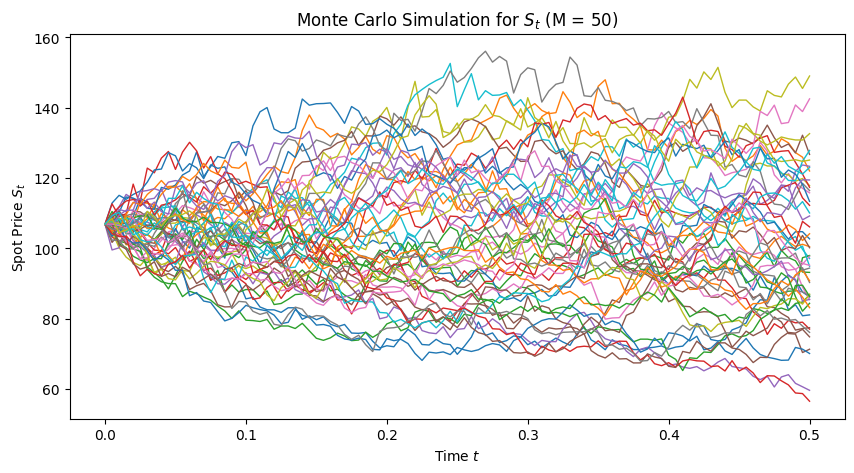

50 simulated paths of how crude oil spot price evolves under the log-XOU process


In [56]:
import matplotlib.pyplot as plt

def plot_simulated_paths(dynamics, N=100, M=20, T=0.5, seed=42):
    """
    Simulates and plots M paths of the XOU process for S_t = exp(X_t)
    """
    dt = T / N
    kappa = dynamics.kappa
    alpha = dynamics.alpha
    sigma = dynamics.sigma
    X0 = np.log(dynamics.S0)

    # Initialize array to store paths
    X_paths = np.zeros((M, N+1))
    X_paths[:, 0] = X0

    rng = np.random.default_rng(seed)

    for n in range(N):
        dWt = rng.normal(0.0, np.sqrt(dt), size=M)
        X_paths[:, n+1] = X_paths[:, n] + kappa * (alpha - X_paths[:, n]) * dt + sigma * dWt

    # Convert X_t to S_t
    S_paths = np.exp(X_paths)
    time_grid = np.linspace(0, T, N+1)

    # Plot
    plt.figure(figsize=(10, 5))
    for i in range(M):
        plt.plot(time_grid, S_paths[i], lw=1)

    plt.title(f"Monte Carlo Simulation for $S_t$ (M = {M})")
    plt.xlabel("Time $t$")
    plt.ylabel("Spot Price $S_t$")
    plt.grid(False)
    plt.show()

num_simulations = 50
plot_simulated_paths(hw6dynamics, N=100, M=num_simulations, T=0.5, seed=1)
print(f"{num_simulations} simulated paths of how crude oil spot price evolves under the log-XOU process")

Explanation for this part:

X_paths[:, n+1] = X_paths[:, n] + kappa * (alpha - X_paths[:, n]) * dt + sigma * dWt

This is the Euler-Maruyama discretization, how we move price forwrad one tiny step in time. Given where the price is right now, where is it likely to be in 5 minutes?

The Anchor (Current State): X_paths[:, n]
This is where you are now. [:, n] simply means we are doign this for all (n=50) simulated paths simultaneously.

The Deterministic Drift: kappa * (alpha - X_paths[:, n]) * dt 
This is the rubber band pulling the price back to the long-term value. 
This is the forces that push prices back towards the 'fair' long-term value:

Alpha - X = This is the gap. 
- If the current price X is lower than the long-term mean (alpha), the number is positive (price wants to go up).
- If the current price X is higher than the long-term mean (alpha), the number is negative (price wants to go down).

Kappa = Speed of the correction. A high kappa means the market is very efficient at correcting 'overpriced' oil.

dt = This scales the movement to a specific time step (one day or one hour)

The Shock (Random noise): sigma * dWt
- This is the news, something that makes the price shifts upwards or downwards
- sigma is the volatility, how loud the news is
- dWt = the random hit, a random number that decides if the news is good or bad. 




